In [1]:
import numpy as np
import pandas as pd
import random
import datetime
import sys
import tfs
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('output1.csv',index_col='Date: dt.date',parse_dates=True,encoding='gbk')[['AL:close:主力粘合 ']]
data.columns = ['AL_main'] #读取数据

In [3]:
data.sort_index(ascending=True,inplace=True) #时序排列

In [4]:
AL = data[~data['AL_main'].isna()][['AL_main']] #去空值

In [5]:
AL.columns = ['main']

In [6]:
data = AL
#训练集
train = data.loc[:'2017',:]
rate = train['main']/train['main'].shift(1)
rate.name = 'rate'

In [7]:
test = data.loc[:'2020-5-21',:] #测试集

In [8]:
# 准备好长短两个周期的参数集
high = ['ma2','ma4','ma6','ma8','ma10']
low = ['ma15','ma30','ma45','ma60']
high_half = ['ma1','ma2','ma3','ma4','ma5']
low_half = ['ma7','ma15','ma22','ma30'] #减半的时候的指标

In [9]:
x, y, z = np.arange(2,12,2), np.arange(15,75,15), np.array([1,3,5,7,22])
para = np.append(np.append(x,y),z)

In [10]:
#正常的ma
def create_data(sss,para,i=0):
    if sss.shape[1] == 1:
        train = sss.copy() #直接返回series
    else:
        train = sss.iloc[:,i:(i+1)].copy() #可以用dataframe调用
    train.columns = ['main']
    for i in para:
        train[('ma'+str(i))] = train['main'].rolling(i).mean()
    return train

In [11]:
#指数的ma
def create_data_e(sss,para,i=0):
    if sss.shape[1] == 1:
        train = sss.copy()
    else:
        train = sss.iloc[:,i:(i+1)].copy()  
    train.columns = ['main']
    for i in para:
        train[('ma'+str(i))] = train['main'].ewm(span=i).mean()
    return train

## **平行宇宙检验**

In [12]:
s_train = pd.concat([train,rate],axis=1)
s_train = s_train.iloc[1:,:] #对收益率数列进行随机切片

In [13]:
n = len(s_train)
points = np.array([])
point = 0
while n > 0:
    interval = 60 + random.sample(list(range(-5,6)),1)[0]
    point = point + interval
    points = np.append(points, point)
    n = n - interval #进行以60为中心的添加扰动项的随机切片

if points[-1] != len(s_train): #进行最后一个区间划分点的微调
    points[-1] = len(s_train)
points = points.astype(int) #转换为整数型
points = np.append(0,points) #添加分组标志

In [14]:
#开始分组搞事情
s_train['group'] = 0
for i in range(len(points)-1):
    s_train.iloc[points[i]:points[i+1],2] = i + 1 #进行分组标号

In [15]:
index = s_train['group'].unique() #组号 #random.shuffle(index) #随机洗牌#index

In [16]:
'''
进行100次模拟，创造100个平行时空
'''
tot_universe = np.array(s_train['rate'].values)
universe = 100
for j in range(universe):
    para_universe = np.array([])
    random.shuffle(index)  # 随机洗牌
    for i in range(len(index)):
        rates = s_train[s_train['group'] == index[i]].loc[:, 'rate'].values
        para_universe = np.append(para_universe, rates)
    
    tot_universe = np.vstack((tot_universe, para_universe)) #假设：总体的分布是一定的，然后时间序列之间的相关性不会太大

In [17]:
def rate_to_price(para_universe):
    series = np.array([1000])
    for i in para_universe:
        series = np.append(series, series[-1] * i)
    return series

In [18]:
series = np.apply_along_axis(rate_to_price,1,tot_universe)
series = series.T
sss = pd.DataFrame(series)
sss.index=data.loc[:'2017'].index

In [12]:
sss = pd.read_csv('平行时空数据/平行宇宙AL.csv',index_col=0)

In [13]:
'''
补充数据完整性
'''
add_data = create_data(data,para)
append = add_data.loc['2018':,]
append.index = add_data.loc['2018':,].index #补充数据

add_data_e = create_data_e(data,para)
append_e = add_data_e.loc['2018':,]
append_e.index = add_data_e.loc['2018':,].index

In [14]:
'''
开始训练 ΔTF0.003 others0.015
'''
#排名汇总
rank_base_sum = np.array([])
rank_sum = np.array([]) 
rank_e_sum = np.array([])

returns = data['main'] / data['main'].shift(1) - 1 #收益率
kl = np.sqrt(252)*np.std(returns.loc['2017':'2021'])*0.7 #上行敏感阈值
ks = - np.sqrt(252)*np.std(returns.loc['2017':'2021'])*0.4 #下行敏感阈值
cos = 0.2389198448279757
delta = 0.015 * ((np.std((data/data.shift(1) - 1))*np.sqrt(252))['main']) / cos

In [15]:
kl,ks,delta

(0.11279285163652855, -0.06445305807801632, 0.01037938335125729)

In [16]:
for k in range(sss.shape[1]): #平行时空循环
    sharp_train_base = np.array([])
    sharp_train = np.array([])
    sharp_train_e = np.array([])
    for i in range(len(high)): #高频循环
        for j in range(len(low)): #低频循环
            p_data = create_data(sss, para, k)
            #p_data = pd.concat([p_data,append],axis=0)
            p_train = create_data(sss, para, k) #构建所在平行时空下的价格序列
            
            p_data_e = create_data_e(sss, para, k)
            #p_data_e = pd.concat([p_data_e,append_e],axis=0)
            p_train_e = create_data_e(sss, para, k) #构建指数加权平均的价格序列
            '''
            基础版双均线进行平行宇宙选择
            '''
            diff = p_train.loc[:,high[i]] - p_train.loc[:,low[j]]
            cash = 10000
            balance_base = tfs.trend_follow_n(cash,p_data,p_train,diff)
            s_base,d_base,perform_base = tfs.performance(balance_base,p_train)
            sharp_train_base = np.append(sharp_train_base,s_base)
            '''
            改进版双均线进行平行宇宙选择
            '''
            diff = p_train.loc[:,high[i]] - p_train.loc[:,low[j]]
            diff1 = p_train.loc[:,high_half[i]] - p_train.loc[:,low_half[j]]
            cash = 10000
            balance = tfs.trend_follow_k_delta(cash, p_data, p_train, diff, diff1, kl, ks, delta, low[j])
            s, d, perform = tfs.performance(balance,p_train)
            sharp_train = np.append(sharp_train,s) #记录夏普比率
            '''
            指数加权平均双均线进行平行宇宙选择
            '''
            diff_e = p_data_e.loc[:,high[i]] - p_data_e.loc[:,low[j]]
            cash = 10000
            balance_e = tfs.trend_follow_n(cash,p_data_e,p_train_e,diff_e)
            s_e,d_e,perform_e = tfs.performance(balance_e,p_train_e)
            sharp_train_e = np.append(sharp_train_e,s_e)
    #基础版        
    rk_train_base = pd.Series(sharp_train_base).rank(ascending=False).values #降序排列
    #rk_train_base = rk_train_base.astype('int') #转换为整形
    rank_base_sum = np.append(rank_base_sum,rk_train_base)
    #改进版
    rk_train = pd.Series(sharp_train).rank(ascending=False).values #降序排列
    #rk_train = rk_train.astype('int') #转换为整形
    rank_sum = np.append(rank_sum,rk_train)
    #指数版
    rk_train_e = pd.Series(sharp_train_e).rank(ascending=False).values #降序排列
    #rk_train_e = rk_train_e.astype('int') #转换为整形
    rank_e_sum = np.append(rank_e_sum,rk_train_e)

In [17]:
rank_base_result = rank_base_sum.reshape(sss.shape[1],-1)
rank_result = rank_sum.reshape(sss.shape[1],-1)
rank_e_result = rank_e_sum.reshape(sss.shape[1],-1)

In [18]:
'''
排序结果汇总
'''
junzhi_base,biaozhuncha_base = np.mean(rank_base_result,axis=0),np.std(rank_base_result,axis=0)
junzhi,biaozhuncha = np.mean(rank_result,axis=0),np.std(rank_result,axis=0)
junzhi_e,biaozhuncha_e = np.mean(rank_e_result,axis=0),np.std(rank_e_result,axis=0)
ratio_plt = pd.DataFrame({'junzhi':junzhi,'biaozhuncha':biaozhuncha,
                          'junzhi_base':junzhi_base,'biaozhuncha_base':biaozhuncha_base,
                          'junzhi_e':junzhi_e,'biaozhuncha_e':biaozhuncha_e})
ratio_plt['long'] = np.array(list(range(15,75,15)) * len(high))
ratio_plt['short'] = np.repeat(list(range(2,12,2)),len(low))

**改进版双均线**

In [19]:
ratio = np.array([])
for i in range(rank_result.shape[1]):
    first = len(np.where(rank_result[:,i]<=3)[0]) #历史上排名前三占比最多
    ratio = np.append(ratio ,first / rank_result.shape[0]) #胜率

In [20]:
#排名前三占比最多的参数
for i in range(3):
    print(high[(np.argsort(ratio)[-3:] // 4)[i]],low[(np.argsort(ratio)[-3:] % 4)[i]])

ma6 ma60
ma4 ma60
ma2 ma60


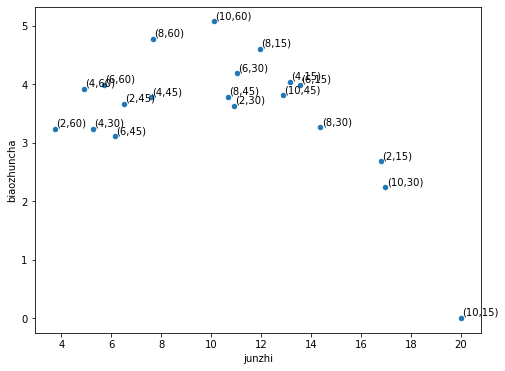

In [21]:
ratio_plt.plot(kind='scatter',x='junzhi',y='biaozhuncha',figsize=(8,6)) #画图显示均值和标准差的分布情况
for i in range(len(ratio_plt)):
    plt.text(ratio_plt['junzhi'][i]+0.05,ratio_plt['biaozhuncha'][i]+0.05,'('+str(ratio_plt['short'][i])+','+str(ratio_plt['long'][i])+')')

In [22]:
high[np.where(rank_result[0,].reshape(5,-1) == min(rank_result[0,]))[0][0]], low[np.where(rank_result[0,].reshape(5,-1) == min(rank_result[0,]))[1][0]]

('ma6', 'ma60')

选出5组参数：CU 四组一象限参数：(2,60) (4,30) (4,60) (6,45) 当前场景下夏普比最大参数：(6,60)

In [23]:
compare = [['ma2','ma60','ma1','ma30'],['ma4','ma60','ma2','ma30'],
           ['ma4','ma60','ma2','ma30'],['ma6','ma45','ma3','ma22'],
           ['ma6','ma60','ma3','ma30']]

sharp_select = np.array([])
for c in compare:
    tr_data = create_data(train, para, 0)
    tr_train = create_data(train, para, 0)
    diff = tr_train.loc[:,c[0]] - tr_train.loc[:,c[1]]
    diff1 = tr_train.loc[:,c[2]] - tr_train.loc[:,c[3]]
    cash = 10000
    balance = tfs.trend_follow_k_delta(cash, tr_data, tr_train, diff, diff1, kl, ks, delta,c[1])
    s, d, perform = tfs.performance(balance,tr_train)
    sharp_select = np.append(sharp_select,s)

for i in range(-1,-3,-1):
    print(compare[np.argsort(sharp_select)[i]][:2], sharp_select[np.argsort(sharp_select)[i]])

['ma6', 'ma60'] 0.811
['ma2', 'ma60'] 0.751


夏普比从大到小排序：(6,60)0.811 (2,60)0.751

**普通双均线**

In [24]:
ratio = np.array([])
for i in range(rank_base_result.shape[1]):
    first = len(np.where(rank_base_result[:,i]<=3)[0])
    ratio = np.append(ratio ,first / rank_base_result.shape[0]) #胜率

#ratio.reshape(5,-1)

In [25]:
#排名前三占比最多的参数
for i in range(3):
    print(high[(np.argsort(ratio)[-3:] // 4)[i]],low[(np.argsort(ratio)[-3:] % 4)[i]])

ma10 ma15
ma2 ma30
ma8 ma15


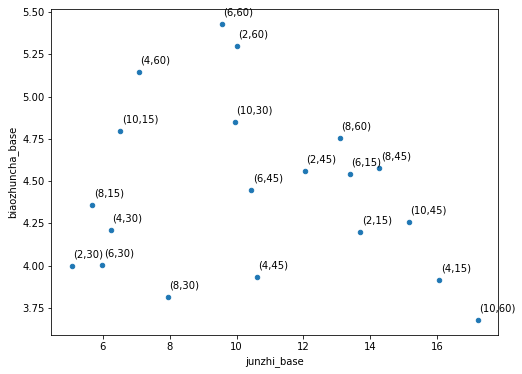

In [26]:
ratio_plt.plot(kind='scatter',x='junzhi_base',y='biaozhuncha_base',figsize=(8,6)) #画图显示均值和标准差的分布情况
for i in range(len(ratio_plt)):
    plt.text(ratio_plt['junzhi_base'][i]+0.05,ratio_plt['biaozhuncha_base'][i]+0.05,'('+str(ratio_plt['short'][i])+','+str(ratio_plt['long'][i])+')')

In [27]:
high[np.where(rank_base_result[0,].reshape(5,-1) == min(rank_base_result[0,]))[0][0]], low[np.where(rank_base_result[0,].reshape(5,-1) == min(rank_base_result[0,]))[1][0]]

('ma8', 'ma15')

选出5组参数：CU 四组一象限参数：(2,30) (6,30) (4,30) (10,15)当前场景下夏普比最大参数：(8,15)

In [29]:
compare = [['ma2','ma30'],['ma6','ma30'],
           ['ma4','ma30'],['ma10','ma15'],['ma8','ma15']]

sharp_select = np.array([])
for c in compare:
    tr_data = create_data(train, para, 0)
    tr_train = create_data(train, para, 0)
    diff = tr_train.loc[:,c[0]] - tr_train.loc[:,c[1]]
    cash = 10000
    balance = tfs.trend_follow_n(cash, tr_data, tr_train, diff)
    s, d, perform = tfs.performance(balance,tr_train)
    sharp_select = np.append(sharp_select,s)

for i in range(-1,-3,-1):
    print(compare[np.argsort(sharp_select)[i]][:2], sharp_select[np.argsort(sharp_select)[i]])

['ma8', 'ma15'] 0.861
['ma6', 'ma30'] 0.843


夏普比从大到小排序：(6,60)0.811 (2,60)0.751

夏普比从大到小排序：(8,15)0.861 (6,30)0.843

**指数双均线**

In [30]:
ratio = np.array([])
for i in range(rank_e_result.shape[1]):
    first = len(np.where(rank_e_result[:,i]<=3)[0])
    ratio = np.append(ratio ,first / rank_e_result.shape[0]) #胜率

In [31]:
#排名前三占比最多的参数
for i in range(3):
    print(high[(np.argsort(ratio)[-3:] // 4)[i]],low[(np.argsort(ratio)[-3:] % 4)[i]])

ma2 ma15
ma8 ma15
ma10 ma15


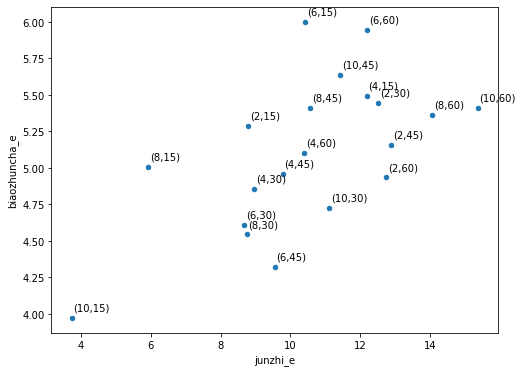

In [32]:
ratio_plt.plot(kind='scatter',x='junzhi_e',y='biaozhuncha_e',figsize=(8,6)) #画图显示均值和标准差的分布情况
for i in range(len(ratio_plt)):
    plt.text(ratio_plt['junzhi_e'][i]+0.05,ratio_plt['biaozhuncha_e'][i]+0.05,'('+str(ratio_plt['short'][i])+','+str(ratio_plt['long'][i])+')')

In [33]:
high[np.where(rank_e_result[0,].reshape(5,-1) == min(rank_e_result[0,]))[0][0]], low[np.where(rank_e_result[0,].reshape(5,-1) == min(rank_e_result[0,]))[1][0]]

('ma10', 'ma15')

选出5组参数：CU 四组一象限参数：(8,15)(2,15)(8,30)(6,30) 当前场景下夏普比最大参数：(10,15)

In [34]:
compare = [['ma8','ma15'],['ma2','ma15'],
           ['ma8','ma30'],['ma6','ma30'],['ma10','ma15']]

sharp_select = np.array([])
for c in compare:
    tr_data = create_data_e(train, para, 0)
    tr_train = create_data_e(train, para, 0)
    diff = tr_train.loc[:,c[0]] - tr_train.loc[:,c[1]]
    cash = 10000
    balance = tfs.trend_follow_n(cash, tr_data, tr_train, diff)
    s, d, perform = tfs.performance(balance,tr_train)
    sharp_select = np.append(sharp_select,s)

for i in range(-1,-3,-1):
    print(compare[np.argsort(sharp_select)[i]][:2], sharp_select[np.argsort(sharp_select)[i]])

['ma10', 'ma15'] 0.93
['ma8', 'ma15'] 0.872


夏普比从大到小排序：(6,60)0.811 (2,60)0.751

夏普比从大到小排序：(8,15)0.861 (6,30)0.843

夏普比从大到小排序：(10,15)0.930 (8,15)0.872

> **切片法选出最终参数：改进版DMA(6,60)0.811 (2,60)0.751 指数版(10,15)0.930 （8，15）0.872**

## **滚动检验**

In [15]:
'''
训练集和测试集长度：均为两年，即488 (244*2)，同时半年一个滚动
考虑相对排名的变化
'''
#网格遍历，将参数网络的结果进行汇总，从而方便求解夏普比排名前后变化的标准差
if len(train)<976:
    print('无法进行滚动测试！')
else:
    sharp_chg_base = np.zeros(len(high)*len(low))
    sharp_chg = np.zeros(len(high)*len(low)) #最终的结果汇总
    sharp_chg_e = np.zeros(len(high)*len(low))
    xiabiao = list(range(0,len(train)-975,122))
    if xiabiao[-1] != (len(train)-976):
        xiabiao.append(len(train)-976)

    for k in xiabiao:#滚动测试
        sharp_train_base,sharp_test_base = np.array([]), np.array([])
        sharp_train, sharp_test = np.array([]), np.array([])
        sharp_train_e, sharp_test_e = np.array([]), np.array([])

        for i in range(len(high)): #高频循环
            for j in range(len(low)): #低频循环
                '''
                训练样本
                '''
                r_train = train.iloc[(0+k):(488+k),:]
                tr_data, tr_train = create_data(r_train, para, 0), create_data(r_train, para, 0)
                tr_data_e, tr_train_e = tr_data.copy(), create_data_e(r_train, para, 0)
                diff = tr_train.loc[:,high[i]] - tr_train.loc[:,low[j]]
                diff1 = tr_train.loc[:,high_half[i]] - tr_train.loc[:,low_half[j]]
                diff_e = tr_train_e.loc[:,high[i]] - tr_train_e.loc[:,low[j]]
                cash = 10000
                balance_base = tfs.trend_follow_n(cash, tr_data, tr_train, diff)
                cash = 10000
                diff = tr_train.loc[:,high[i]] - tr_train.loc[:,low[j]]
                diff1 = tr_train.loc[:,high_half[i]] - tr_train.loc[:,low_half[j]]
                balance = tfs.trend_follow_k_delta(cash, tr_data, tr_train, diff, diff1, kl, ks, delta)
                cash = 10000
                balance_e = tfs.trend_follow_n(cash, tr_data_e, tr_train_e, diff_e)
                s_base, d_base, perform_base = tfs.performance(balance_base,tr_train)
                s, d, perform = tfs.performance(balance,tr_train)
                s_e, d_e, perform_e = tfs.performance(balance_e, tr_train_e)
                #记录夏普比
                sharp_train_base, sharp_train, sharp_train_e = np.append(sharp_train_base, s_base), np.append(sharp_train, s), np.append(sharp_train_e, s_e)
                '''
                测试样本
                '''
                r_test = train.iloc[(0+k):(976+k),:]
                te_data, te_train = create_data(r_test, para, 0), create_data(r_test, para, 0)
                te_data_e, te_train_e = te_data.copy(), create_data(r_test, para, 0)
                diff = te_train.loc[:,high[i]] - te_train.loc[:,low[j]]
                diff1 = te_train.loc[:,high_half[i]] - te_train.loc[:,low_half[j]]
                diff_e = te_train_e.loc[:,high[i]] - te_train_e.loc[:,low[j]]
                cash = 10000
                balance_base = tfs.trend_follow_n(cash,te_data, te_train, diff)
                cash = 10000
                diff = te_train.loc[:,high[i]] - te_train.loc[:,low[j]]
                diff1 = te_train.loc[:,high_half[i]] - te_train.loc[:,low_half[j]]
                balance = tfs.trend_follow_k_delta(cash, te_data, te_train, diff, diff1, kl, ks, delta)
                cash = 10000
                balance_e = tfs.trend_follow_n(cash, te_data_e, te_train_e, diff_e)
                daily_base = pd.Series(balance_base) / pd.Series(balance_base).shift(1) - 1
                daily = pd.Series(balance) / pd.Series(balance).shift(1) - 1  # 每日收益率
                daily_e = pd.Series(balance_e) / pd.Series(balance_e).shift(1) - 1
                s_base = np.sqrt(252)*np.mean(daily_base.iloc[-488:])/np.std(daily_base.iloc[-488:])
                s = np.sqrt(252)*np.mean(daily.iloc[-488:])/np.std(daily.iloc[-488:])
                s_e = np.sqrt(252)*np.mean(daily_e.iloc[-488:])/np.std(daily_e.iloc[-488:])
                sharp_test_base, sharp_test, sharp_test_e = np.append(sharp_test_base,s_base), np.append(sharp_test,s), np.append(sharp_test_e,s_e)
                #print('*'*50)
        #降序排列
        rk_train_base, rk_test_base = pd.Series(sharp_train_base).rank(ascending=False).values, pd.Series(sharp_test_base).rank(ascending=False).values
        rk_train, rk_test = pd.Series(sharp_train).rank(ascending=False).values, pd.Series(sharp_test).rank(ascending=False).values
        rk_train_e, rk_test_e = pd.Series(sharp_train_e).rank(ascending=False).values, pd.Series(sharp_test_e).rank(ascending=False).values
        #统计本次的夏普在所有备选参数中排名的变化，用train-test变好就正数，变坏就是负数
        chg_base, chg, chg_e = (rk_train_base - rk_test_base), (rk_train - rk_test), (rk_train_e - rk_test_e)
        #将结果合并
        sharp_chg_base, sharp_chg, sharp_chg_e = np.vstack((sharp_chg_base,chg_base)), np.vstack((sharp_chg,chg)), np.vstack((sharp_chg_e,chg_e))

In [16]:
means_base = np.mean(sharp_chg_base,axis=0)
std_base = np.std(sharp_chg_base,axis=0)
means = np.mean(sharp_chg,axis=0)
std = np.std(sharp_chg,axis=0)
means_e = np.mean(sharp_chg_e,axis=0)
std_e = np.std(sharp_chg_e,axis=0)
summary = pd.DataFrame({'means_base':means_base,'std_base':std_base,
                        'means':means,'std':std,
                        'means_e':means_e,'std_e':std_e})
summary['long'] = np.array(list(range(15,75,15)) * len(high))
summary['short'] = np.repeat([2,4,6,8,10],len(low))

**改进版双均线**

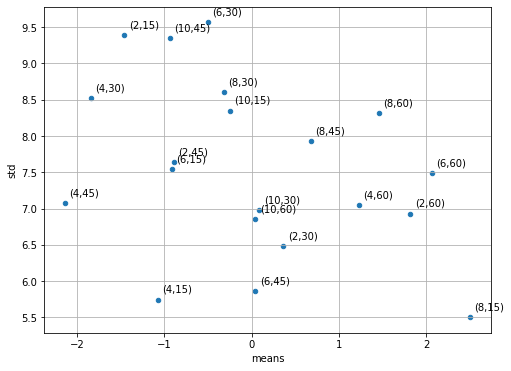

In [17]:
summary.plot(kind='scatter',x='means',y='std',figsize=(8,6),grid=True)
for i in range(len(summary)):
    plt.text(summary['means'][i]+0.05,summary['std'][i]+0.1,'('+str(summary['short'][i])+','+str(summary['long'][i])+')')

rank变化前4名：(8,15)(2,60)(2,30)(6,45)

In [18]:
compare = [['ma8','ma15','ma4','ma7'],['ma2','ma60','ma1','ma30'],
           ['ma2','ma30','ma1','ma15'],['ma6','ma45','ma3','ma22']]

sharp_select = np.array([])
for c in compare:
    tr_data = create_data(train, para, 0)
    tr_train = create_data(train, para, 0)
    diff = tr_train.loc[:,c[0]] - tr_train.loc[:,c[1]]
    diff1 = tr_train.loc[:,c[2]] - tr_train.loc[:,c[3]]
    cash = 10000
    balance = tfs.trend_follow_k_delta(cash, tr_data, tr_train, diff, diff1, kl, ks, delta)
    s, d, perform = tfs.performance(balance,tr_train)
    sharp_select = np.append(sharp_select,s)

for i in range(-1,-3,-1):
    print(compare[np.argsort(sharp_select)[i]][:2], sharp_select[np.argsort(sharp_select)[i]])

['ma8', 'ma15'] 0.769
['ma2', 'ma30'] 0.73


**保留(8,15)0.769  (2,30)0.730**

**普通版双均线**

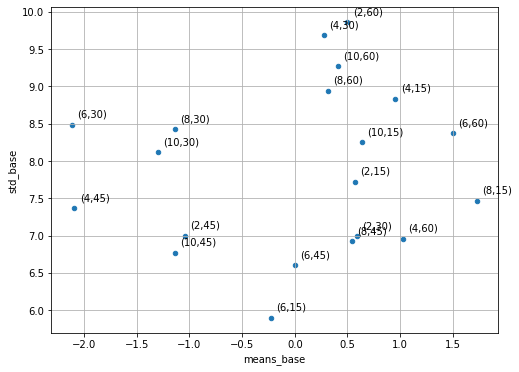

In [39]:
summary.plot(kind='scatter',x='means_base',y='std_base',figsize=(8,6),grid=True)
for i in range(len(summary)):
    plt.text(summary['means_base'][i]+0.05,summary['std_base'][i]+0.1,'('+str(summary['short'][i])+','+str(summary['long'][i])+')')

rank变化前4名：(8,15)(4,60)(8,45)(6,45)

In [40]:
compare = [['ma8','ma15'],['ma4','ma60'],
           ['ma8','ma45'],['ma6','ma45']]

sharp_select = np.array([])
for c in compare:
    tr_data = create_data(train, para, 0)
    tr_train = create_data(train, para, 0)
    diff = tr_train.loc[:,c[0]] - tr_train.loc[:,c[1]]
    cash = 10000
    balance = tfs.trend_follow_n(cash, tr_data, tr_train, diff)
    s, d, perform = tfs.performance(balance,tr_train)
    sharp_select = np.append(sharp_select,s)

for i in range(-1,-3,-1):
    print(compare[np.argsort(sharp_select)[i]], sharp_select[np.argsort(sharp_select)[i]])

['ma8', 'ma15'] 0.861
['ma4', 'ma60'] 0.799


**保留(8,15)0.769  (2,30)0.730**

**保留(8,15)0.861  (4,60)0.799**

**指数版双均线**

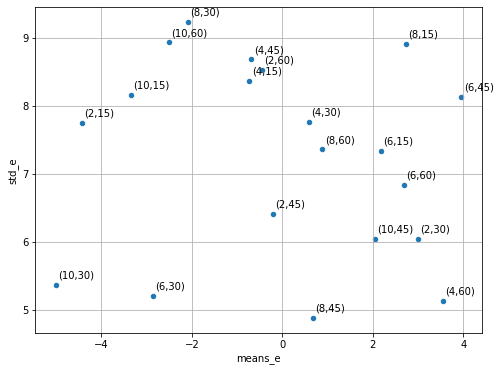

In [19]:
summary.plot(kind='scatter',x='means_e',y='std_e',figsize=(8,6),grid=True)
for i in range(len(summary)):
    plt.text(summary['means_e'][i]+0.05,summary['std_e'][i]+0.1,'('+str(summary['short'][i])+','+str(summary['long'][i])+')')

rank变化前4名：(4,60)(2,30)(8,45)(10,45)

In [20]:
compare = [['ma4','ma60'],['ma2','ma30'],
           ['ma8','ma45'],['ma10','ma45']]

sharp_select = np.array([])
for c in compare:
    tr_data = create_data_e(train, para, 0)
    tr_train = create_data_e(train, para, 0)
    diff = tr_train.loc[:,c[0]] - tr_train.loc[:,c[1]]
    cash = 10000
    balance = tfs.trend_follow_n(cash, tr_data, tr_train, diff)
    s, d, perform = tfs.performance(balance,tr_train)
    sharp_select = np.append(sharp_select,s)

for i in range(-1,-3,-1):
    print(compare[np.argsort(sharp_select)[i]], sharp_select[np.argsort(sharp_select)[i]])

['ma2', 'ma30'] 0.625
['ma4', 'ma60'] 0.616


**保留(8,15)0.769  (2,30)0.730**

**保留(8,15)0.861  (4,60)0.799**

**保留(2,30)0.625  (4,60)0.616**

> **滚动验证法选出最终参数：普通版DMA(8,15)0.861(4,60)0.799 改进版(8,15)0.769**

> **切片法选出最终参数：改进版DMA(6,60)0.811 (2,60)0.751 指数版(10,15)0.930 （8，15）0.872**

## 所有备选模型（约6个）在测试集上测试效果

In [35]:
test = data.loc[:'2020-5-21',:] #测试集

In [36]:
compare = [['ma6','ma60','ma3','ma30'],['ma2','ma60','ma1','ma30'],
           ['ma10','ma15'],['ma8','ma15']]
index = ['enhance','enhance','exp','exp']
train_sharp = [0.811, 0.751, 0.930, 0.872]
test_result = pd.DataFrame({'index':index,'compare':compare,'train_sharp':train_sharp})

In [37]:
sharp_select = np.array([])
balances = np.zeros(len(test))
for i in range(len(test_result)):
    if test_result.iloc[i,0]=='base':
        te_data = create_data(test, para, 0)
        te_train = create_data(test, para, 0)
        diff = te_train.loc[:,test_result.iloc[i,1][0]] - te_train.loc[:,test_result.iloc[i,1][1]]
        cash = 10000
        balance = tfs.trend_follow_n(cash, te_data, te_train, diff)
        balances = np.vstack((balances,balance))
        daily = pd.Series(balance) / pd.Series(balance).shift(1) - 1  # 每日收益率
        daily.index = test.index
        #s = np.sqrt(252)*np.mean(daily)/np.std(daily)
        s = np.sqrt(252)*np.mean(daily.loc['2018':])/np.std(daily.loc['2018':])
        sharp_select = np.append(sharp_select,s)
    elif test_result.iloc[i,0]=='enhance':
        te_data = create_data(test, para, 0)
        te_train = create_data(test, para, 0)
        diff = te_train.loc[:,test_result.iloc[i,1][0]] - te_train.loc[:,test_result.iloc[i,1][1]]
        diff1 = te_train.loc[:,test_result.iloc[i,1][2]] - te_train.loc[:,test_result.iloc[i,1][3]]
        cash = 10000
        balance = tfs.trend_follow_k_delta(cash, te_data, te_train, diff, diff1, kl, ks, delta,test_result.iloc[i,1][1])
        balances = np.vstack((balances,balance))
        daily = pd.Series(balance) / pd.Series(balance).shift(1) - 1  # 每日收益率
        daily.index = test.index
        #s = np.sqrt(252)*np.mean(daily)/np.std(daily)
        s = np.sqrt(252)*np.mean(daily.loc['2018':])/np.std(daily.loc['2018':])
        sharp_select = np.append(sharp_select,s)
    else:
        te_data = create_data_e(test, para, 0)
        te_train = create_data_e(test, para, 0)
        diff = te_train.loc[:,test_result.iloc[i,1][0]] - te_train.loc[:,test_result.iloc[i,1][1]]
        cash = 10000
        balance = tfs.trend_follow_n(cash, te_data, te_train, diff)
        balances = np.vstack((balances,balance))
        daily = pd.Series(balance) / pd.Series(balance).shift(1) - 1  # 每日收益率
        daily.index = test.index
        #s = np.sqrt(252)*np.mean(daily)/np.std(daily)
        s = np.sqrt(252)*np.mean(daily.loc['2018':])/np.std(daily.loc['2018':])
        sharp_select = np.append(sharp_select,s)

In [38]:
moneys = pd.DataFrame((balances[1:,].T) / 10000,index=test.index,
                      columns=['en6,60','en2,60',
                               'exp10,15','exp8,15'])
moneys['index'] = test / test.iloc[0]

<AxesSubplot:xlabel='Date: dt.date'>

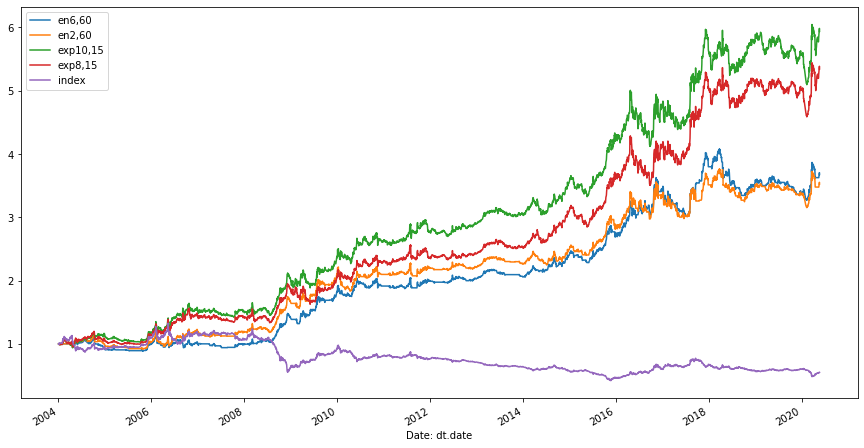

In [40]:
moneys.loc[:,:].plot(figsize=(15,8))

In [41]:
test_result['test_sharp'] = sharp_select

In [42]:
test_result.sort_values(by='test_sharp',ascending=False)

,index,compare,train_sharp,test_sharp
3,exp,"[ma8, ma15]",0.872,0.255604
2,exp,"[ma10, ma15]",0.930,0.244812
1,enhance,"[ma2, ma60, ma1, ma30]",0.751,0.065820
0,enhance,"[ma6, ma60, ma3, ma30]",0.811,-0.091132


In [43]:
test = data.loc[:,:] #真实集
sharp_select = np.array([])
balances = np.zeros(len(test))
for i in range(len(test_result)):
    if test_result.iloc[i,0]=='base':
        te_data = create_data(test, para, 0)
        te_train = create_data(test, para, 0)
        diff = te_train.loc[:,test_result.iloc[i,1][0]] - te_train.loc[:,test_result.iloc[i,1][1]]
        cash = 10000
        balance = tfs.trend_follow_n(cash, te_data, te_train, diff)
        balances = np.vstack((balances,balance))
        daily = pd.Series(balance) / pd.Series(balance).shift(1) - 1  # 每日收益率
        daily.index = test.index
        #s = np.sqrt(252)*np.mean(daily)/np.std(daily)
        s = np.sqrt(252)*np.mean(daily.loc['2018':])/np.std(daily.loc['2018':])
        sharp_select = np.append(sharp_select,s)
    elif test_result.iloc[i,0]=='enhance':
        te_data = create_data(test, para, 0)
        te_train = create_data(test, para, 0)
        diff = te_train.loc[:,test_result.iloc[i,1][0]] - te_train.loc[:,test_result.iloc[i,1][1]]
        diff1 = te_train.loc[:,test_result.iloc[i,1][2]] - te_train.loc[:,test_result.iloc[i,1][3]]
        cash = 10000
        balance = tfs.trend_follow_k_delta(cash, te_data, te_train, diff, diff1, kl, ks, delta,test_result.iloc[i,1][1])
        balances = np.vstack((balances,balance))
        daily = pd.Series(balance) / pd.Series(balance).shift(1) - 1  # 每日收益率
        daily.index = test.index
        #s = np.sqrt(252)*np.mean(daily)/np.std(daily)
        s = np.sqrt(252)*np.mean(daily.loc['2018':])/np.std(daily.loc['2018':])
        sharp_select = np.append(sharp_select,s)
    else:
        te_data = create_data_e(test, para, 0)
        te_train = create_data_e(test, para, 0)
        diff = te_train.loc[:,test_result.iloc[i,1][0]] - te_train.loc[:,test_result.iloc[i,1][1]]
        cash = 10000
        balance = tfs.trend_follow_n(cash, te_data, te_train, diff)
        balances = np.vstack((balances,balance))
        daily = pd.Series(balance) / pd.Series(balance).shift(1) - 1  # 每日收益率
        daily.index = test.index
        #s = np.sqrt(252)*np.mean(daily)/np.std(daily)
        s = np.sqrt(252)*np.mean(daily.loc['2018':])/np.std(daily.loc['2018':])
        sharp_select = np.append(sharp_select,s)

In [44]:
test_result['real_sharp'] = sharp_select
test_result.sort_values(by='real_sharp',ascending=False)

,index,compare,train_sharp,test_sharp,real_sharp
3,exp,"[ma8, ma15]",0.872,0.255604,0.864133
1,enhance,"[ma2, ma60, ma1, ma30]",0.751,0.065820,0.703760
2,exp,"[ma10, ma15]",0.930,0.244812,0.668955
0,enhance,"[ma6, ma60, ma3, ma30]",0.811,-0.091132,0.632147


<AxesSubplot:xlabel='Date: dt.date'>

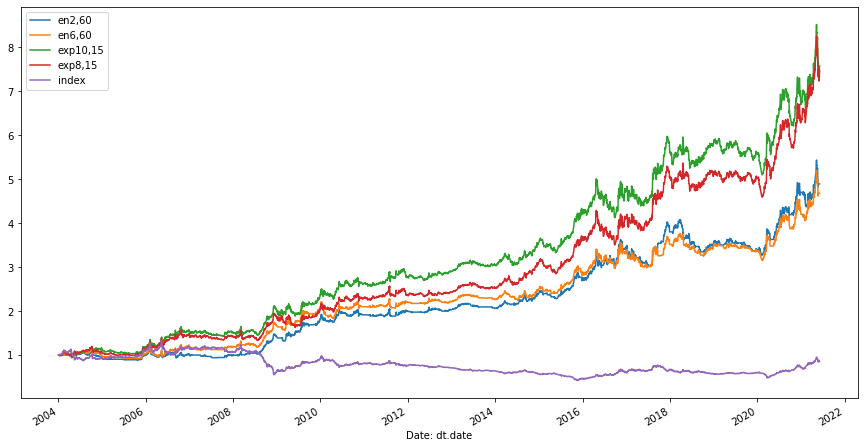

In [47]:
moneys = pd.DataFrame((balances[1:,].T) / 10000,index=test.index,
                      columns=['en2,60','en6,60',
                               'exp10,15','exp8,15'])
moneys['index'] = test / test.iloc[0]
moneys.loc[:,:].plot(figsize=(15,8))

测试长周期参数参数平原

In [40]:
para = np.append(para,np.array([12,13,14,16,17,18,7,9]))
iso = [['ma10','ma12','ma5','ma6'],['ma10','ma13','ma5','ma6'],
           ['ma10','ma14','ma5','ma7'],['ma10','ma15','ma5','ma7'],
           ['ma10','ma16','ma5','ma8'],['ma10','ma17','ma5','ma8'],['ma10','ma18','ma5','ma9']]
iso_result = pd.DataFrame({'iso':iso})

<AxesSubplot:>

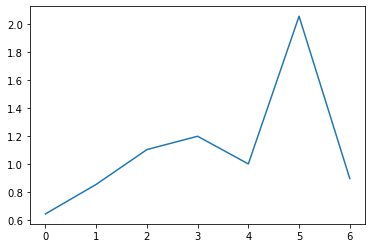

In [41]:
test = data.loc[:,:] #真实集
iso_sharp = np.array([])
for i in range(len(iso_result)):
    te_data = create_data(test, para, 0)
    te_train = create_data(test, para, 0)
    diff = te_train.loc[:,iso_result.iloc[i,0][0]] - te_train.loc[:,iso_result.iloc[i,0][1]]
    diff1 = te_train.loc[:,iso_result.iloc[i,0][2]] - te_train.loc[:,iso_result.iloc[i,0][3]]
    cash = 10000
    balance = tfs.trend_follow_k_delta(cash, te_data, te_train, diff, diff1, kl, ks, delta)
    daily = pd.Series(balance) / pd.Series(balance).shift(1) - 1  # 每日收益率
    daily.index = test.index
    s = np.sqrt(252)*np.mean(daily.loc['2020-5-22':])/np.std(daily.loc['2020-5-22':])
    iso_sharp = np.append(iso_sharp,s)
    
iso_result['test_sharp'] = iso_sharp
iso_result.loc[:,'test_sharp'].plot()